# "Parts of form" explorer

developed by Kow Kuroda (kow.kuroda@gmail.com)

Created 2024/09/13

Modifications
2025/08/01 i) added handling of Englsh WN3 word classification; ii) added gender sub-classification for Irish;
2025/08/02 i) added handling of Welsh;

In [45]:
#!pip install -U pyLDAvis
#!pip install -U pandas

In [46]:
## imports
import os, sys
import pprint as pp
import unicodedata

In [47]:
## 一つ上の階層のファイルを見るように設定
sys.path.append(os.path.join(os.path.dirname("__file__"), '..'))

In [48]:
## install Cython if necessary
#!conda install Cython -y

In [49]:
## Cython module の生成 (必要に応じて)
#!python clean setup.py build_ext --inplace

In [50]:
## Cython を使うかどうか
use_Cython = True
if use_Cython:
    %load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [51]:
## doc settings
doc_types        = [ 'spell', 'sound' ]
doc_type          = doc_types[0]
print(f"doc_type: {doc_type}")

### boundary handling
mark_boundaries     = True
boundary_mark       = "#"
print(f"mark_boundaries with {boundary_mark}: {doc_type}")

## sizes
max_doc_size        = 11
min_doc_size        =  5
print(f"max_doc_size: {max_doc_size}")
print(f"min_doc_size: {min_doc_size}")

doc_type: spell
mark_boundaries with #: spell
max_doc_size: 11
min_doc_size: 5


In [52]:
## term settings
ngram_is_inclusive  = True
inclusion_degree    = None # or 1 # smaller values give better results

## term setting
#ngram_is_skippy       = False
skippy_means_extended = False

gap_mark            = "…"
seg_joint           = ""

### accent handling
suppress_accents    = True
accent_marks        = [ "ˈ", "ˌ" ] 
if doc_type == 'sound':
    if suppress_accents:
        accent_status = "-unaccented"
    else:
        accent_stratus = "-accented"
else:
    accent_status = ""
print(f"accent_status: {accent_status}")

accent_status: 


In [53]:
## select target files
import glob
data_dir1      = "data/open-dict-ipa/data1"
data_dir2      = "data/open-dict-ipa/data1a"
data_dir3      = "data/wn3"
data_dir4      = "data/irish"
data_dir5      = "data/welsh"
target_files   = glob.glob(f"{data_dir1}/*")
target_files2  = glob.glob(f"{data_dir2}/*")
target_files.extend(target_files2)
target_files3  = glob.glob(f"{data_dir3}/*")
target_files.extend(target_files3)
target_files4  = glob.glob(f"{data_dir4}/*")
target_files.extend(target_files4)
target_files5  = glob.glob(f"{data_dir5}/*")
target_files.extend(target_files5)
#
pp.pprint(target_files)

['data/open-dict-ipa/data1/yue.csv.gz',
 'data/open-dict-ipa/data1/vi_S.csv.gz',
 'data/open-dict-ipa/data1/de.csv.gz',
 'data/open-dict-ipa/data1/jam.csv.gz',
 'data/open-dict-ipa/data1/ro.csv.gz',
 'data/open-dict-ipa/data1/fa.csv.gz',
 'data/open-dict-ipa/data1/zh_hant.csv.gz',
 'data/open-dict-ipa/data1/sw.csv.gz',
 'data/open-dict-ipa/data1/ar.csv.gz',
 'data/open-dict-ipa/data1/es_MX.csv.gz',
 'data/open-dict-ipa/data1/vi_C.csv.gz',
 'data/open-dict-ipa/data1/ma.csv.gz',
 'data/open-dict-ipa/data1/fi.csv.gz',
 'data/open-dict-ipa/data1/eo.csv.gz',
 'data/open-dict-ipa/data1/fr_QC.csv.gz',
 'data/open-dict-ipa/data1/es_ES.csv.gz',
 'data/open-dict-ipa/data1/en_US.csv.gz',
 'data/open-dict-ipa/data1/en_UK.csv.gz',
 'data/open-dict-ipa/data1/nb.csv.gz',
 'data/open-dict-ipa/data1/nl.csv.gz',
 'data/open-dict-ipa/data1/sv.csv.gz',
 'data/open-dict-ipa/data1/or.csv.gz',
 'data/open-dict-ipa/data1/zh_hans.csv.gz',
 'data/open-dict-ipa/data1/fr_FR.csv.gz',
 'data/open-dict-ipa/data1/vi_

# select language

In [54]:
## key must be part of a file name 
target_lang_dict = {    'en_US' : 'English (US)',
                        'en_UK' : 'English (UK)',
                        'en_N_only' : 'English noun (WN)',
                        'en_V_only' : 'English verb (WN)',
                        'en_A_only' : 'English adj (WN)',
                        'en_R_only' : 'English adv (WN)',
                        'ar'    : 'Arabic',
                        'de'    : 'German',
                        'de_N_only' : 'German noun',
                        'de_non_N_only' : 'German non-noun',
                        'eo'    : 'Esperanto',
                        'es_ES' : 'Spanish (Spain)',
                        'es_MX' : 'Spanish (Mexico)',
                        'fi'    : 'Finnish',
                        'fr_FR' : 'French (France)',
                        'fr_QC' : 'French (Quebec)',
                        'is'    : 'Icelandic',
                        'ir'    : 'Irish',
                        'nb'    : 'Norwegian',
                        'nl'    : 'Dutch',
                        'ro'    : 'Romanian',
                        'sw'    : 'Swahili',
                        'we'    : 'Welsh' }
## proper language selection
target_lang_keys = [    'en_US', # 0
                        'en_UK', # 1
                        'en_N_only', # 2
                        'en_V_only', # 3
                        'en_A_only', # 4
                        'en_R_only', # 5
                        'ar', # 6
                        'de', # 7
                        'de_N_only', # 8
                        'de_non_N_only', # 9
                        'eo', 'es_ES', 'es_MX',
                        'fi', 'fr_FR', 'fr_QC',
                        'is', 'nb', 'nl', 'ro', 'sw',
                        'ir', 'we' # These lack sound
                    ]

In [55]:
## select language
target_lang_key  = target_lang_keys[-1]
print(f"target_lang_key: {target_lang_key}")
target_lang_name = target_lang_dict[target_lang_key]
print(f"target lang: {target_lang_name} [{target_lang_key}]")

target_lang_key: we
target lang: Welsh [we]


In [56]:
## select word class
selects_word_class = True

##
target_word_class = None
target_word_classes = [ 'N_only_w_gender', 'N_only',
                        'A_only_w_gender', 'A_only',
                        'non_N_only',
                        'R_only',
                        'V_only_w_inflect', 'V_only' ]
# non_N_only only for German; R_only is not available for Irish, Welsh
target_word_class = target_word_classes[0]
print(f"target_word_class: {target_word_class}")

##
selects_gender  = True
selects_inflect = False
print(f"selects_gender: {selects_gender}")
print(f"selects_inflect: {selects_inflect}")    

target_word_class: N_only_w_gender
selects_gender: True
selects_inflect: False


In [57]:
## select files

## make a reserve for re-run
try:
    target_files_original
except NameError:
    target_files_original = target_files.copy()
##
if selects_word_class:
    lang_key = target_lang_key.split("_")[0]
    print(f"lang_key: {lang_key}")
    print(f"target_word_class: {target_word_class}")
    if not target_word_class != 'non_N_only':
        target_files = [ f for f in target_files_original if not f"non_{target_word_class}" in f ]
    if type(target_word_class) == 'list':
        target_files = [ f for f in target_files if any(wc in f for wc in target_word_class) and lang_key in f ]
    else:
        target_files = [ f for f in target_files if target_word_class in f and lang_key in f ]
##
pp.pprint(target_files)

lang_key: we
target_word_class: N_only_w_gender
['data/welsh/welsh-spell-N_only_w_gender.csv']


In [58]:
## get source data from files
import pandas as pd
import gzip

for target_file in target_files:
    print(f"processing: {target_file}")
    #
    if target_lang_key in ['wl', 'we']:
        col_names = ['spell', 'lemma', 'POS0', 'POS', 'freq']
    elif target_lang_key in ['ir', ]:
        col_names = ['spell', 'POS']
    else:
        col_names = ['spell', 'sound']
    ##
    if target_file.endswith(".gz"):
        with gzip.open(target_file, "rt") as f:
            df = pd.read_csv(f, encoding = 'utf8', header = None, names = col_names )
    else:
        with open(target_file, "rt") as f:
            df = pd.read_csv(f, encoding = 'utf8', header = None, names = col_names )

    ## normalize characters
    df['spell'] = df['spell'].apply(lambda x: unicodedata.normalize('NFC', str(x)))

    ## modify sound
    try:
        sounds = df['sound'].apply(lambda x: x.strip('/') )
        sounds = [ x.split("/,")[0] for x in sounds ] # picks up only the first of multiple entries
        df['sound'] = sounds
    except (AttributeError, KeyError):
        pass
    #
df.sample(30)

processing: data/welsh/welsh-spell-N_only_w_gender.csv


,spell,lemma,POS0,POS,freq
2641,haur,aur,Noun,Noun.common.masc.sg,1
1651,ebol,ebol,Noun,Noun.common.masc.sg,2
3397,thrwyn,trwyn,Noun,Noun.common.masc.sg,2
3212,siâp,siâp,Noun,Noun.common.masc.sg,1
302,anghyfiawnder,anghyfiawnder,Noun,Noun.common.masc.sg,2
800,faes,bae,Noun,Noun.common.masc.pl,6
707,glo,clo,Noun,Noun.common.masc.sg,1
1301,tharth,tarth,Noun,Noun.common.masc.sg,1
3501,bregethwr,pregethwr,Noun,Noun.common.masc.sg,7
3106,isaac,isaac,Noun,Noun.proper.unk.unk,23


### Noun gender

In [59]:
## select gender value
#selects_gender = False
target_genders = [ 'fem', 'masc', 'neu' ] # neuter is effective for German only
target_gender = target_genders[0]
print(f"target_gender: {target_gender}")

target_gender: fem


In [60]:
## make a reserve for re-run
df_origin = df.copy()

In [61]:
## filter df
import re
pattern = re.compile(f".*{target_gender}.*")

## Welsh
if selects_gender and target_lang_key in [ 'we', 'wl' ] and target_word_class in [ 'N_only_w_gender', 'A_only_w_gender' ]:
    df = df_origin[df_origin['POS'].apply(lambda x: bool(pattern.match(x)))]
## Irish
elif selects_gender and target_lang_key in [ 'ir' ] and target_word_class in [ 'N_only_w_gender' ]:
    df = df_origin[df_origin['POS'].apply(lambda x: pattern.match(x))]
## Other
else:
    target_gender = None
#
df

,spell,lemma,POS0,POS,freq
0,chwaer,chwaer,Noun,Noun.common.fem.sg,49
5,cyfrol,cyfrol,Noun,Noun.common.fem.sg,8
8,ffeithiau,ffaith,Noun,Noun.common.fem.pl,7
9,flwyddyn,blwyddyn,Noun,Noun.common.fem.sg,14
10,ystod,ystod,Noun,Noun.common.fem.sg,9
...,...,...,...,...,...
4562,ynysoedd,ynys,Noun,Noun.common.fem.pl,1
4565,gweledigaethau,gweledigaeth,Noun,Noun.common.fem.pl,1
4568,ysgolion,ysgol,Noun,Noun.common.fem.pl,1
4573,chymru,cymru,Noun,Noun.proper.fem.unk,1


### Verb inflection

In [62]:
## select inflection value
#selects_inflect = True
target_inflect = ['inf', 'indic', 'imper', 'subj',
                   'p1', 'p2', 'p3', 'p0'
                  'sg', 'pl' ] # neuter is effective for German only
target_inflect = target_inflect[5]
print(f"target_inflect: {target_inflect}")

## disable selects_gender
if selects_inflect:
    selects_gender = False

target_inflect: p2


In [63]:
## filer df
import re
if selects_inflect and target_lang_key in [ 'we', 'wl' ] and target_word_class in [ 'V_only_w_inflect' ]:
    pattern = re.compile(f".*{target_inflect}.*")
    df = df_origin[df_origin['POS'].apply(lambda x: bool(pattern.match(x)))]
## Other cases
else:
    target_inflect = None
#
df

,spell,lemma,POS0,POS,freq
0,chwaer,chwaer,Noun,Noun.common.fem.sg,49
5,cyfrol,cyfrol,Noun,Noun.common.fem.sg,8
8,ffeithiau,ffaith,Noun,Noun.common.fem.pl,7
9,flwyddyn,blwyddyn,Noun,Noun.common.fem.sg,14
10,ystod,ystod,Noun,Noun.common.fem.sg,9
...,...,...,...,...,...
4562,ynysoedd,ynys,Noun,Noun.common.fem.pl,1
4565,gweledigaethau,gweledigaeth,Noun,Noun.common.fem.pl,1
4568,ysgolion,ysgol,Noun,Noun.common.fem.pl,1
4573,chymru,cymru,Noun,Noun.proper.fem.unk,1


## sampling

In [64]:
## source sampling
source_sampling          = True
source_sampling_rate     = 0.5
source_sampling_max_size = 3000
len(df)
if source_sampling:
	print(f"source sampling applied")
	if len(df) >= source_sampling_max_size:
		source_sampling_n = source_sampling_max_size
	else:
		source_sampling_n = round(len(df) * source_sampling_rate)
	df = df.sample(source_sampling_n)
else:
	source_sampling_n = None

## remove accent marking
if suppress_accents:
	try:
		df['sound'] = df['sound'].apply(lambda x: "".join([ y for y in list(x) if y not in accent_marks ]))
	except KeyError:
		pass

## add boudary marks
if mark_boundaries:
	df['spell'] = df['spell'].apply(lambda x: f"{boundary_mark}{x}{boundary_mark}")
	try:
		df['sound'] = df['sound'].apply(lambda x: f"{boundary_mark}{x}{boundary_mark}")
	except KeyError:
		pass
#
print(df)

source sampling applied
             spell      lemma  POS0                  POS  freq
2768        #gors#       cors  Noun   Noun.common.fem.sg     2
4503     #dwynwen#    dwynwen  Noun  Noun.proper.fem.unk     1
1349        #rhos#       rhos  Noun   Noun.common.fem.sg     3
3242         #awr#       gawr  Noun   Noun.common.fem.sg     2
4010       #stryd#      stryd  Noun   Noun.common.fem.sg     2
...            ...        ...   ...                  ...   ...
331      #ewyllys#    ewyllys  Noun   Noun.common.fem.sg     3
2789        #ffon#       ffon  Noun   Noun.common.fem.sg     8
3096     #affrica#    affrica  Noun  Noun.proper.fem.unk    11
3426     #cynffon#    cynffon  Noun   Noun.common.fem.sg     2
4008  #chystrawen#  cystrawen  Noun   Noun.common.fem.sg     1

[572 rows x 5 columns]


In [65]:
## generate 1-grams for spell and sound
## spell
df['sp_1gram'] = df['spell'].apply(lambda x: list(str(x)))
# add column of size
df['sp_size'] = df['sp_1gram'].apply(lambda x: len(x))
# add column of count of '-' inside
df['hyphen'] = df['sp_1gram'].apply(lambda x: list(x).count("-"))
# add column of count of '.' inside
df['period'] = df['sp_1gram'].apply(lambda x: list(x).count("."))
## sound
# takes the first entry, removes '/' around
try:
    df['sn_1gram'] = df['sound'].apply(lambda x: list(x) )
except (TypeError, KeyError):
    pass
# add column of size
try:
    df['sn_size'] = df['sn_1gram'].apply(lambda x: len(x))
except KeyError:
    pass
## check
df

,spell,lemma,POS0,POS,freq,sp_1gram,sp_size,hyphen,period
2768,#gors#,cors,Noun,Noun.common.fem.sg,2,"[#, g, o, r, s, #]",6,0,0
4503,#dwynwen#,dwynwen,Noun,Noun.proper.fem.unk,1,"[#, d, w, y, n, w, e, n, #]",9,0,0
1349,#rhos#,rhos,Noun,Noun.common.fem.sg,3,"[#, r, h, o, s, #]",6,0,0
3242,#awr#,gawr,Noun,Noun.common.fem.sg,2,"[#, a, w, r, #]",5,0,0
4010,#stryd#,stryd,Noun,Noun.common.fem.sg,2,"[#, s, t, r, y, d, #]",7,0,0
...,...,...,...,...,...,...,...,...,...
331,#ewyllys#,ewyllys,Noun,Noun.common.fem.sg,3,"[#, e, w, y, l, l, y, s, #]",9,0,0
2789,#ffon#,ffon,Noun,Noun.common.fem.sg,8,"[#, f, f, o, n, #]",6,0,0
3096,#affrica#,affrica,Noun,Noun.proper.fem.unk,11,"[#, a, f, f, r, i, c, a, #]",9,0,0
3426,#cynffon#,cynffon,Noun,Noun.common.fem.sg,2,"[#, c, y, n, f, f, o, n, #]",9,0,0


In [66]:
## filtering raw_data by size
print(f"term_class: {doc_type}")
if "spell" == doc_type:
    df_filtered = df[ (df['sp_size'] <= max_doc_size) & (df['sp_size'] >= min_doc_size) & (df['hyphen'] == 0) & (df['period'] == 0) ]
else:
    df_filtered = df[ (df['sn_size'] <= max_doc_size) & (df['sn_size'] >= min_doc_size) ]
#
df_filtered

term_class: spell


,spell,lemma,POS0,POS,freq,sp_1gram,sp_size,hyphen,period
2768,#gors#,cors,Noun,Noun.common.fem.sg,2,"[#, g, o, r, s, #]",6,0,0
4503,#dwynwen#,dwynwen,Noun,Noun.proper.fem.unk,1,"[#, d, w, y, n, w, e, n, #]",9,0,0
1349,#rhos#,rhos,Noun,Noun.common.fem.sg,3,"[#, r, h, o, s, #]",6,0,0
3242,#awr#,gawr,Noun,Noun.common.fem.sg,2,"[#, a, w, r, #]",5,0,0
4010,#stryd#,stryd,Noun,Noun.common.fem.sg,2,"[#, s, t, r, y, d, #]",7,0,0
...,...,...,...,...,...,...,...,...,...
2442,#ngeneth#,geneth,Noun,Noun.common.fem.sg,11,"[#, n, g, e, n, e, t, h, #]",9,0,0
331,#ewyllys#,ewyllys,Noun,Noun.common.fem.sg,3,"[#, e, w, y, l, l, y, s, #]",9,0,0
2789,#ffon#,ffon,Noun,Noun.common.fem.sg,8,"[#, f, f, o, n, #]",6,0,0
3096,#affrica#,affrica,Noun,Noun.proper.fem.unk,11,"[#, a, f, f, r, i, c, a, #]",9,0,0


In [67]:
## second sampling if needed
second_sampling          = False
second_sampling_rate     = 0.7
len(df_filtered)
if second_sampling:
    df = df_filtered.sample(round(len(df_filtered) * second_sampling_rate))
else:
    df = df_filtered
len(df)

519

# Functions

In [68]:
def add_ngram_to_df(dfx, n_for_ngram: int, skippy: bool, prefix: str = "", seg_joint: str = "", missing_mark: str = gap_mark, max_distance = None, inclusive: bool = ngram_is_inclusive, inclusion_degree = None, use_Cython: bool = False, check: bool = False):
    """
    generic function for adding n-gram column to df with a specified n for ngram
    """
    ## variables
    source_var = f"{prefix}1gram"
    print(f"source_var: {source_var}")
    if skippy:
        target_var = f"{prefix}sk{n_for_ngram}gram"
    else:
        target_var = f"{prefix}{n_for_ngram}gram"
    print(f"target_var: {target_var}")
    
    ##
    unigrams = dfx[source_var]
    if use_Cython:
        import cy_gen_ngrams
        if skippy:
            ngrams = [ [seg_joint.join(x) for x in cy_gen_ngrams.gen_skippy_ngrams(x, n = n_for_ngram, missing_mark = missing_mark, max_distance = max_distance, check = check)] for x in unigrams ]
        else:
            ngrams = [ [seg_joint.join(x) for x in cy_gen_ngrams.gen_ngrams(x, n = n_for_ngram, sep = seg_joint, check = check)] for x in unigrams ]
    else:
        import gen_ngrams
        if skippy:
            ngrams = [ gen_ngrams.gen_skippy_ngrams(x, n = n_for_ngram, sep = seg_joint, missing_mark = missing_mark, max_distance = max_distance, check = check) for x in unigrams ]
        else:
            ngrams = [ gen_ngrams.gen_ngrams(x, n = n_for_ngram, sep = seg_joint, check = check) for x in unigrams ]
    ## 包括的 n-gramの生成
    if inclusive:
        if inclusion_degree is None:
            min_size = 1
        else:
            min_size = (n_for_ngram - inclusion_degree)
        print(f"min_size: {min_size}")
        assert min_size >= 0
        if skippy and n_for_ngram > 2:
            supplement_var = f"{prefix}sk{n_for_ngram - 1}gram"
        else:
            supplement_var = f"{prefix}{n_for_ngram - 1}gram"
        print(f"supplement_var: {supplement_var}")
        for i, g in enumerate(ngrams):
            supplement = [ x for x in list(dfx[supplement_var])[i] if len(x) >= min_size ]
            if len(supplement) > 0:
                g.extend(supplement)
    ## 変数の追加
    dfx[target_var] = ngrams
    ## check result
    print(dfx[target_var])

In [69]:
def get_terms_by_freq_rank(dfx, rank_range: tuple, prefix: str = "", n_for_ngram: int = 2, skippy: bool = False, gap_mark: str = "…", check = False):
    "return list of most N frequent terms"
    import collections
    ## define variables
    if skippy:
        if skippy_means_extended:
            skippiness = "xsk"
        else:
            skippiness = "sk"
    else:
        skippiness = "" 
    var_name = f'{prefix}{skippiness}{n_for_ngram}gram'
    if check:
        print(f"var_name: {var_name}")
    ## main
    G = [ ]
    [ G.extend([x for x in L if len(x.replace(gap_mark, "")) == n_for_ngram]) for L in dfx[var_name] ]
    if check:
        print(G)
    ## filtering data
    highest_rank = min(rank_range)
    lowest_rank  = max(rank_range)
    if check:
        print(f"highest_rank: {highest_rank}; lowest_rank: {lowest_rank}")
    R = collections.Counter(G).most_common(lowest_rank)
    R = R[(highest_rank - 1):]
    if check:
        print(R)
    ## return
    return R

In [70]:
def show_terms_with_ranking(ranking, rank_range: tuple, n_for_ngram: int, skippy: bool, prefix: str = "", lang: str = target_lang_name, word_class: str = target_word_class, gender_val: str = target_gender, inflect_val: str = target_inflect, check = False):
    "display terms with a given frequency rank range"
    ## imports
    import matplotlib.pyplot as plt
    ## variables
    highest_rank = min(rank_range)
    lowest_rank  = max(rank_range)
    if skippy:
        if skippy_means_extended:
            skippiness = "xsk"
        else:
            skippiness = "sk"
    else:
        skippiness = ""
    target_var_name = f"{prefix}{skippiness}{n_for_ngram}g"

    ## get freq data
    ranking = sorted(ranking, key = lambda x: x[1], reverse = False)
    terms, freqs = [ ], [ ]
    for x in ranking:
        term, freq = x[0], x[1]
        if len(term) > 0 and freq > 0:
            terms.append(term)
            freqs.append(freq)

    ## plot
    plt.figure(figsize = (6, 0.25 * len(terms)))
    plt.autoscale(enable = True, axis = 'y', tight = True)
    plt.barh(terms, freqs)
    ##
    if gender_val is not None:
        title_val = f"Freq-ranked distribution [rank {highest_rank} – rank {lowest_rank}] of {target_var_name} from\n{lang} ({source_sampling_n} samples from word_class: {word_class} with: {gender_val}) "
    elif inflect_val is not None:
        title_val = f"Freq-ranked distribution [rank {highest_rank} – rank {lowest_rank}] of {target_var_name} from\n{lang} ({source_sampling_n} samples from word_class: {word_class} with: {inflect_val}) "
    else:
        title_val = f"Freq-ranked distribution [rank {highest_rank} - rank {lowest_rank}] of {target_var_name} from\n{lang} ({source_sampling_n} samples from word_class: {word_class})"
    plt.title(title_val)
    plt.plot()

# Main

In [71]:
# frequency rank range for terms to show
highest_freq_rank_for_terms_to_show = 1
lowest_freq_rank_for_terms_to_show  = 100
rank_range  = (highest_freq_rank_for_terms_to_show, lowest_freq_rank_for_terms_to_show)
print(f"rank_range: {rank_range}")

rank_range: (1, 100)


## Spell

### Non-skippy spell

In [72]:
## spell 2grams
add_ngram_to_df(df, n_for_ngram = 2, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_2gram
min_size: 1
supplement_var: sp_1gram
2768               [#g, go, or, rs, s#, #, g, o, r, s, #]
4503    [#d, dw, wy, yn, nw, we, en, n#, #, d, w, y, n...
1349               [#r, rh, ho, os, s#, #, r, h, o, s, #]
3242                      [#a, aw, wr, r#, #, a, w, r, #]
4010        [#s, st, tr, ry, yd, d#, #, s, t, r, y, d, #]
                              ...                        
2442    [#n, ng, ge, en, ne, et, th, h#, #, n, g, e, n...
331     [#e, ew, wy, yl, ll, ly, ys, s#, #, e, w, y, l...
2789               [#f, ff, fo, on, n#, #, f, f, o, n, #]
3096    [#a, af, ff, fr, ri, ic, ca, a#, #, a, f, f, r...
3426    [#c, cy, yn, nf, ff, fo, on, n#, #, c, y, n, f...
Name: sp_2gram, Length: 519, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_66176/3820207768.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


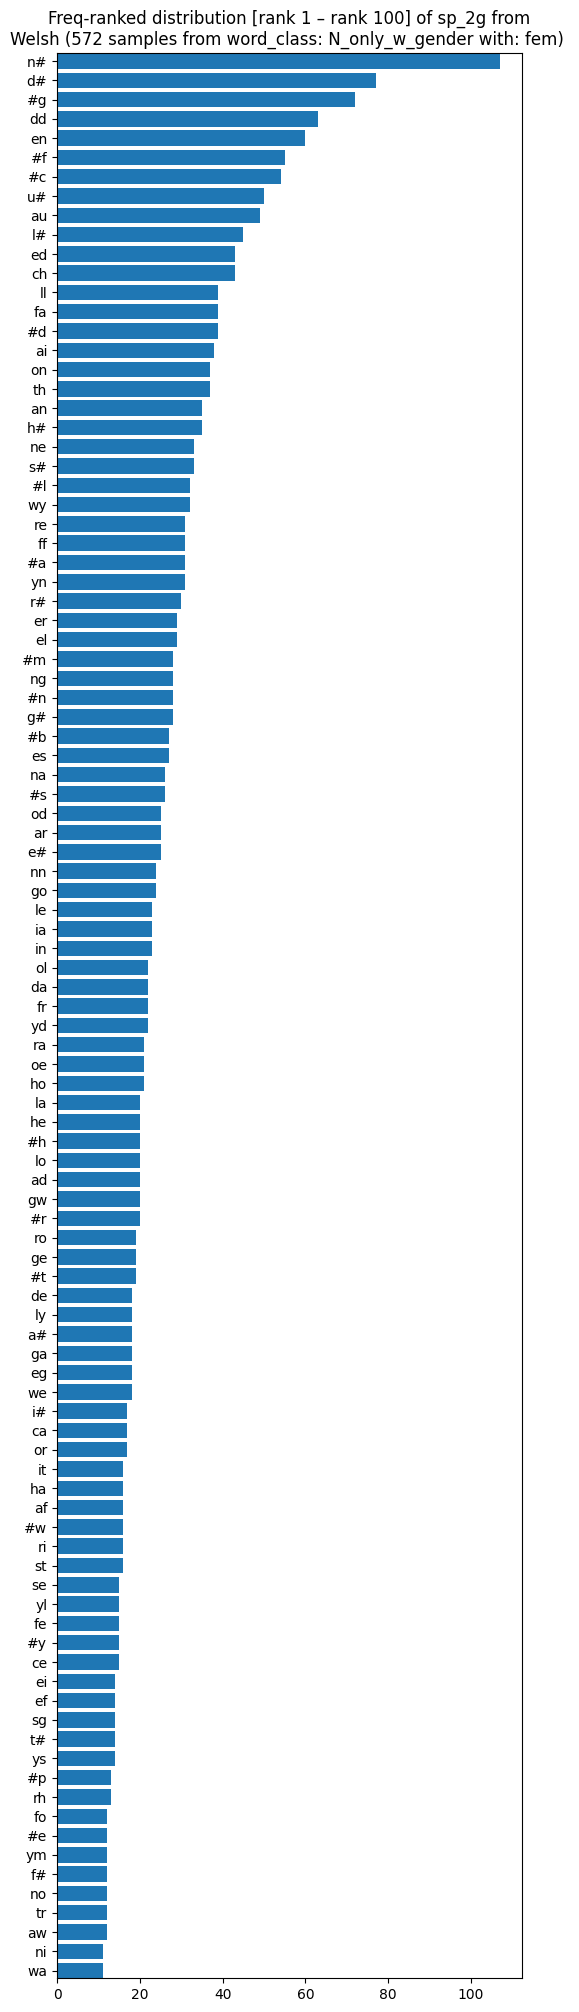

In [73]:
## frequency-ranked view
skippy = False
prefix = "sp_"
n_local = 2
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [74]:
## spell 3grams
add_ngram_to_df(df, n_for_ngram = 3, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_3gram
min_size: 1
supplement_var: sp_2gram
2768    [#go, gor, ors, rs#, #g, go, or, rs, s#, #, g,...
4503    [#dw, dwy, wyn, ynw, nwe, wen, en#, #d, dw, wy...
1349    [#rh, rho, hos, os#, #r, rh, ho, os, s#, #, r,...
3242       [#aw, awr, wr#, #a, aw, wr, r#, #, a, w, r, #]
4010    [#st, str, try, ryd, yd#, #s, st, tr, ry, yd, ...
                              ...                        
2442    [#ng, nge, gen, ene, net, eth, th#, #n, ng, ge...
331     [#ew, ewy, wyl, yll, lly, lys, ys#, #e, ew, wy...
2789    [#ff, ffo, fon, on#, #f, ff, fo, on, n#, #, f,...
3096    [#af, aff, ffr, fri, ric, ica, ca#, #a, af, ff...
3426    [#cy, cyn, ynf, nff, ffo, fon, on#, #c, cy, yn...
Name: sp_3gram, Length: 519, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_66176/3820207768.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


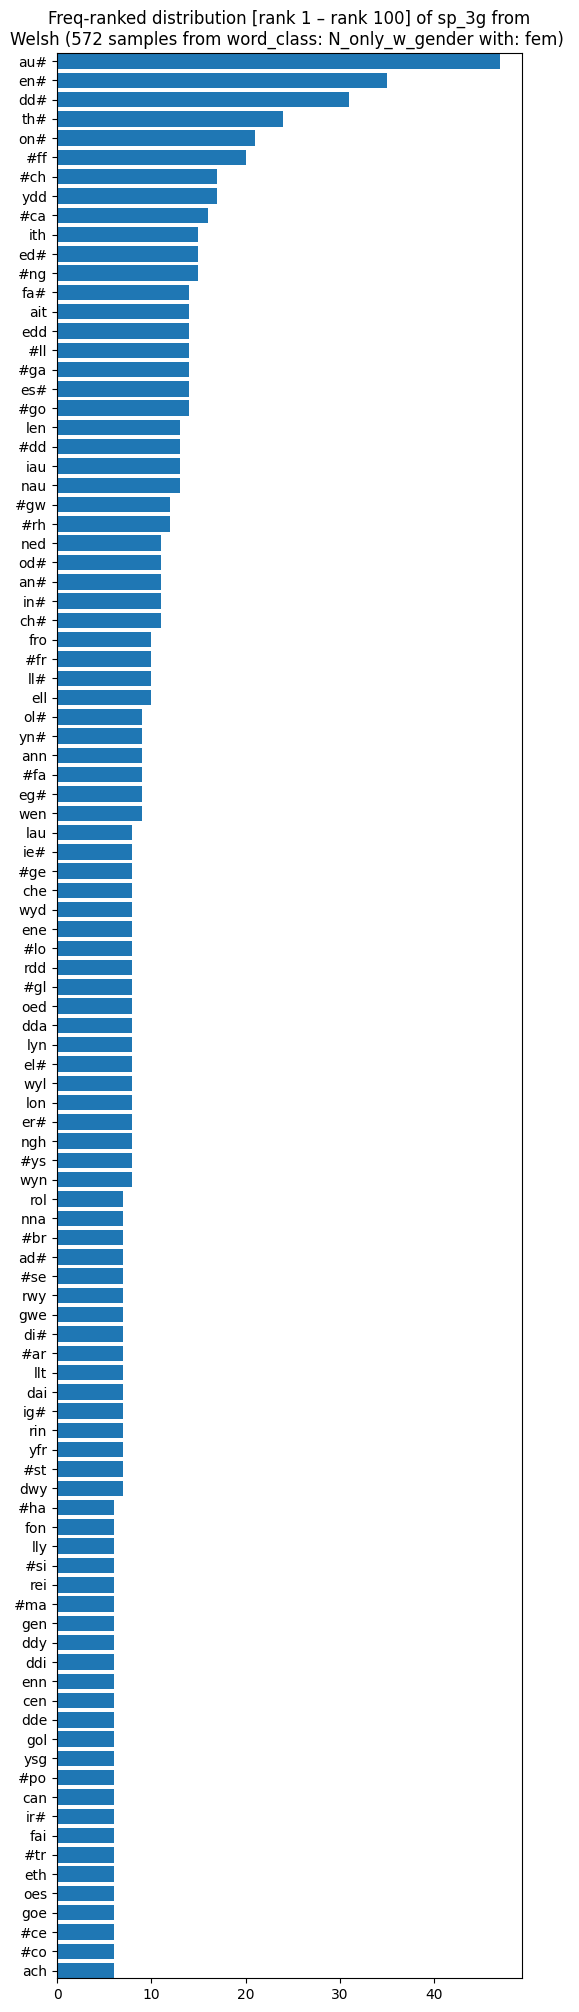

In [75]:
## frequency-ranke view
skippy = False
prefix = "sp_"
n_local = 3
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [76]:
## spell 4grams
add_ngram_to_df(df, n_for_ngram = 4, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_4gram
min_size: 1
supplement_var: sp_3gram
2768    [#gor, gors, ors#, #go, gor, ors, rs#, #g, go,...
4503    [#dwy, dwyn, wynw, ynwe, nwen, wen#, #dw, dwy,...
1349    [#rho, rhos, hos#, #rh, rho, hos, os#, #r, rh,...
3242    [#awr, awr#, #aw, awr, wr#, #a, aw, wr, r#, #,...
4010    [#str, stry, tryd, ryd#, #st, str, try, ryd, y...
                              ...                        
2442    [#nge, ngen, gene, enet, neth, eth#, #ng, nge,...
331     [#ewy, ewyl, wyll, ylly, llys, lys#, #ew, ewy,...
2789    [#ffo, ffon, fon#, #ff, ffo, fon, on#, #f, ff,...
3096    [#aff, affr, ffri, fric, rica, ica#, #af, aff,...
3426    [#cyn, cynf, ynff, nffo, ffon, fon#, #cy, cyn,...
Name: sp_4gram, Length: 519, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_66176/3820207768.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


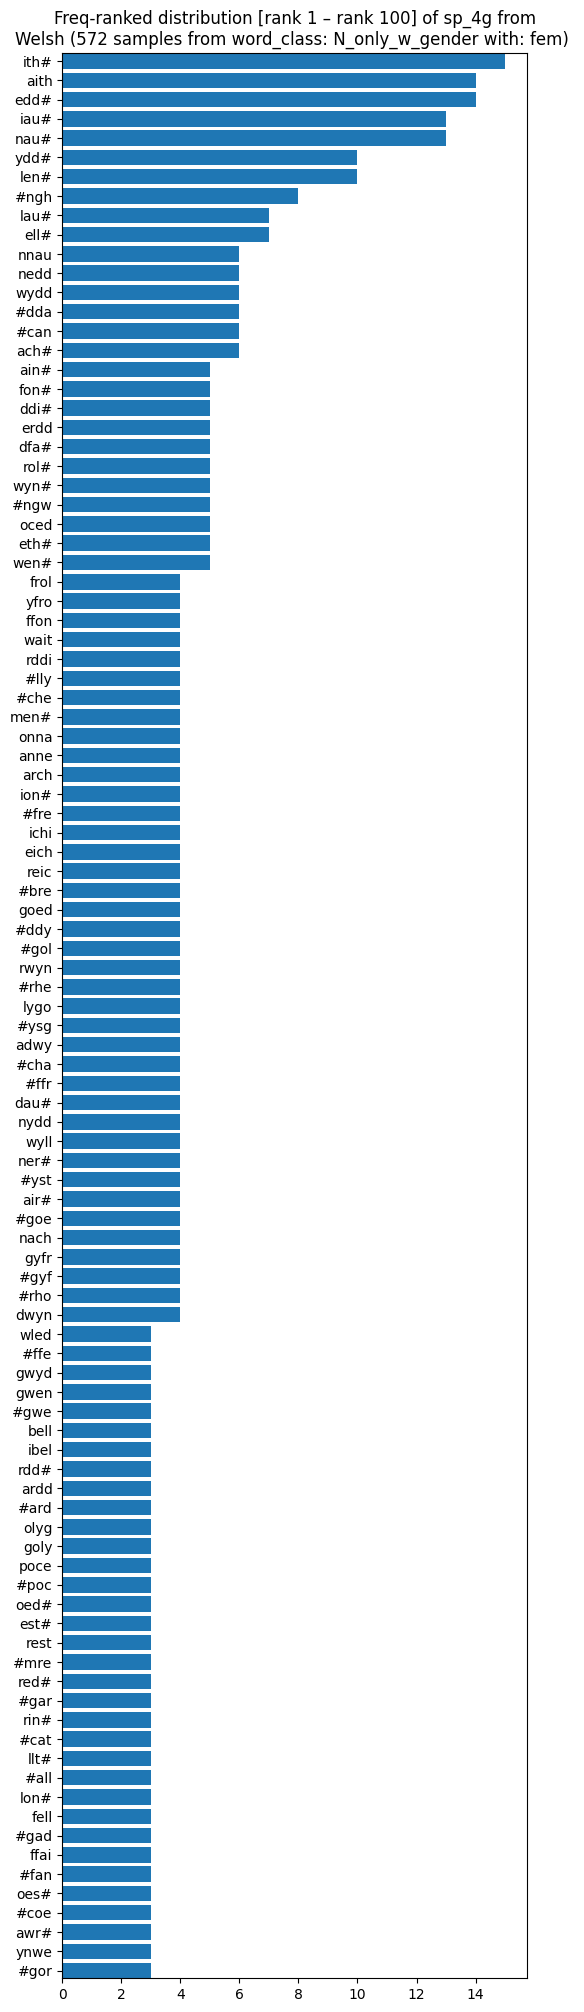

In [77]:
## frequency-ranke view
skippy = False
prefix = "sp_"
n_local = 4
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [78]:
## spell 5grams
add_ngram_to_df(df, n_for_ngram = 5, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_5gram
min_size: 1
supplement_var: sp_4gram
2768    [#gors, gors#, #gor, gors, ors#, #go, gor, ors...
4503    [#dwyn, dwynw, wynwe, ynwen, nwen#, #dwy, dwyn...
1349    [#rhos, rhos#, #rho, rhos, hos#, #rh, rho, hos...
3242    [#awr#, #awr, awr#, #aw, awr, wr#, #a, aw, wr,...
4010    [#stry, stryd, tryd#, #str, stry, tryd, ryd#, ...
                              ...                        
2442    [#ngen, ngene, genet, eneth, neth#, #nge, ngen...
331     [#ewyl, ewyll, wylly, yllys, llys#, #ewy, ewyl...
2789    [#ffon, ffon#, #ffo, ffon, fon#, #ff, ffo, fon...
3096    [#affr, affri, ffric, frica, rica#, #aff, affr...
3426    [#cynf, cynff, ynffo, nffon, ffon#, #cyn, cynf...
Name: sp_5gram, Length: 519, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_66176/3820207768.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


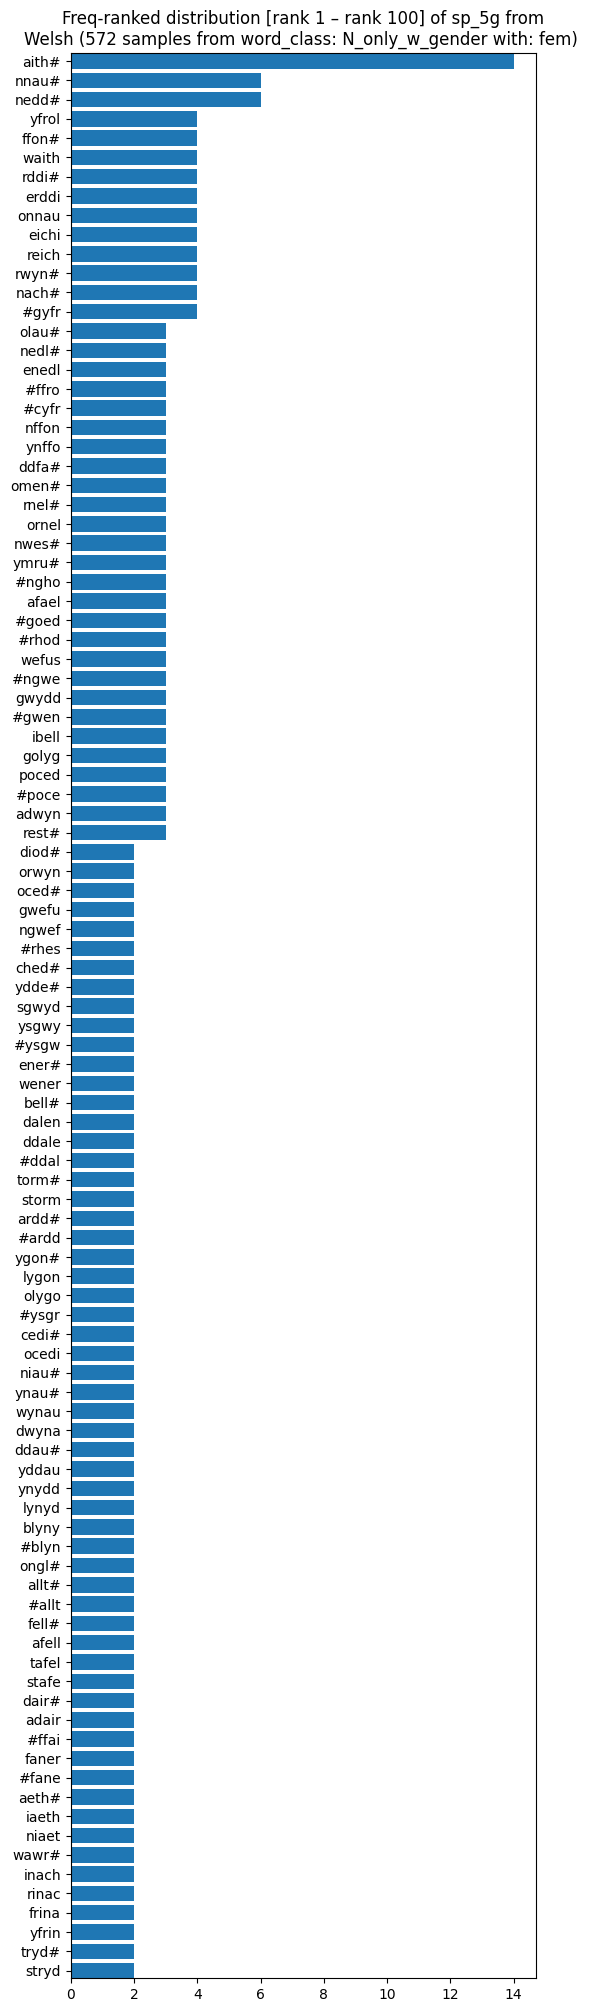

In [79]:
## frequency-rank view
skippy = False
prefix = "sp_"
n_local = 5
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

### skippy spell

In [80]:
## spell skippy 2grams
add_ngram_to_df(df, n_for_ngram = 2, prefix = "sp_", skippy = True, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_sk2gram
min_size: 1
supplement_var: sp_1gram
2768    [#g, #…o, #…r, #…s, #…#, go, g…r, g…s, g…#, or...
4503    [#d, #…w, #…y, #…n, #…w, #…e, #…n, #…#, dw, d…...
1349    [#r, #…h, #…o, #…s, #…#, rh, r…o, r…s, r…#, ho...
3242    [#a, #…w, #…r, #…#, aw, a…r, a…#, wr, w…#, r#,...
4010    [#s, #…t, #…r, #…y, #…d, #…#, st, s…r, s…y, s…...
                              ...                        
2442    [#n, #…g, #…e, #…n, #…e, #…t, #…h, #…#, ng, n…...
331     [#e, #…w, #…y, #…l, #…l, #…y, #…s, #…#, ew, e…...
2789    [#f, #…f, #…o, #…n, #…#, ff, f…o, f…n, f…#, fo...
3096    [#a, #…f, #…f, #…r, #…i, #…c, #…a, #…#, af, a…...
3426    [#c, #…y, #…n, #…f, #…f, #…o, #…n, #…#, cy, c…...
Name: sp_sk2gram, Length: 519, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_66176/3820207768.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


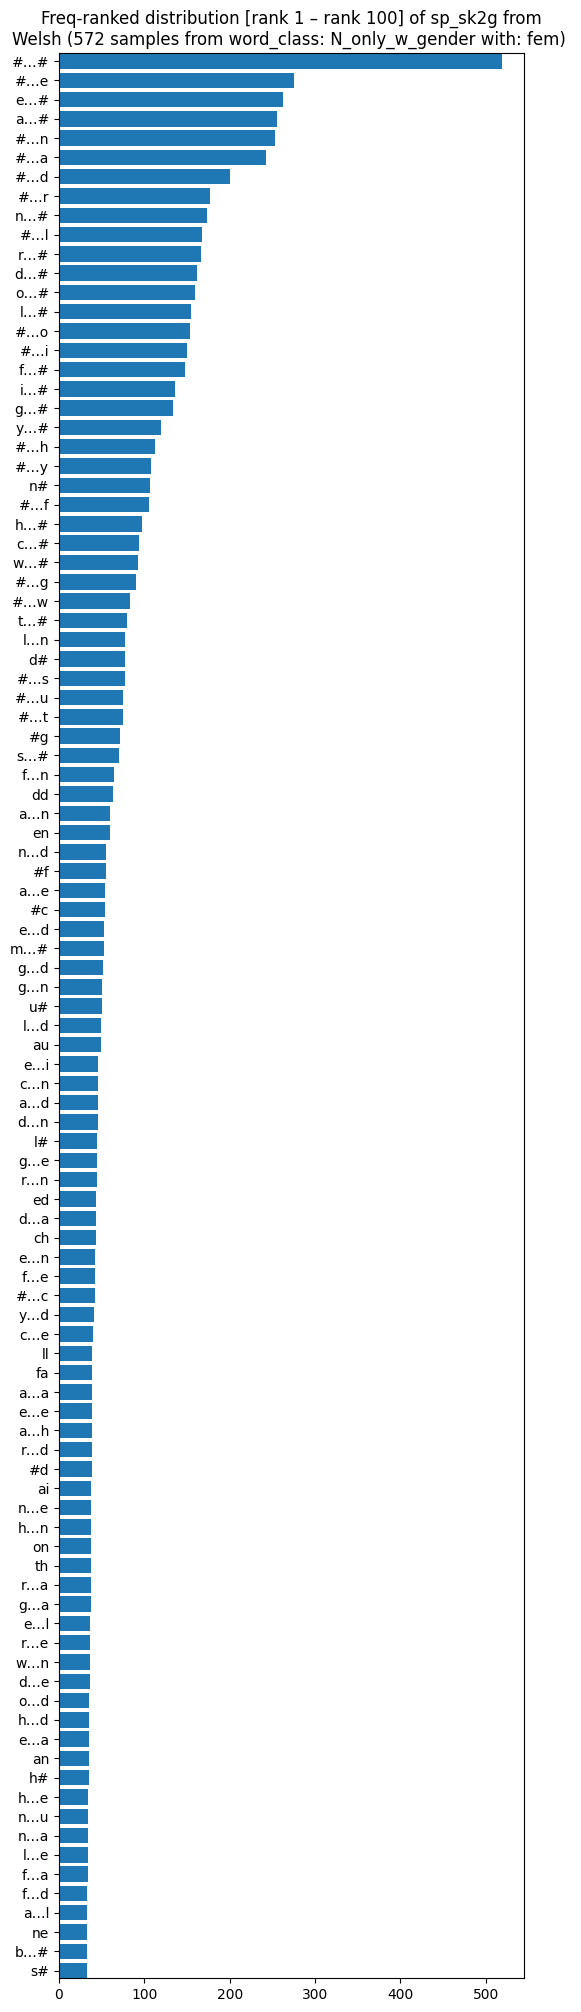

In [81]:
## frequency-ranked view
skippy = True
prefix = "sp_"
n_local = 2
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [82]:
## spell skippy 3grams
add_ngram_to_df(df, n_for_ngram = 3, prefix = "sp_", skippy = True, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_sk3gram
min_size: 1
supplement_var: sp_sk2gram
2768    [#go, #g…r, #g…s, #g…#, #…or, #…o…s, #…o…#, #…...
4503    [#dw, #d…y, #d…n, #d…w, #d…e, #d…n, #d…#, #…wy...
1349    [#rh, #r…o, #r…s, #r…#, #…ho, #…h…s, #…h…#, #…...
3242    [#aw, #a…r, #a…#, #…wr, #…w…#, #…r#, awr, aw…#...
4010    [#st, #s…r, #s…y, #s…d, #s…#, #…tr, #…t…y, #…t...
                              ...                        
2442    [#ng, #n…e, #n…n, #n…e, #n…t, #n…h, #n…#, #…ge...
331     [#ew, #e…y, #e…l, #e…l, #e…y, #e…s, #e…#, #…wy...
2789    [#ff, #f…o, #f…n, #f…#, #…fo, #…f…n, #…f…#, #…...
3096    [#af, #a…f, #a…r, #a…i, #a…c, #a…a, #a…#, #…ff...
3426    [#cy, #c…n, #c…f, #c…f, #c…o, #c…n, #c…#, #…yn...
Name: sp_sk3gram, Length: 519, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_66176/3820207768.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


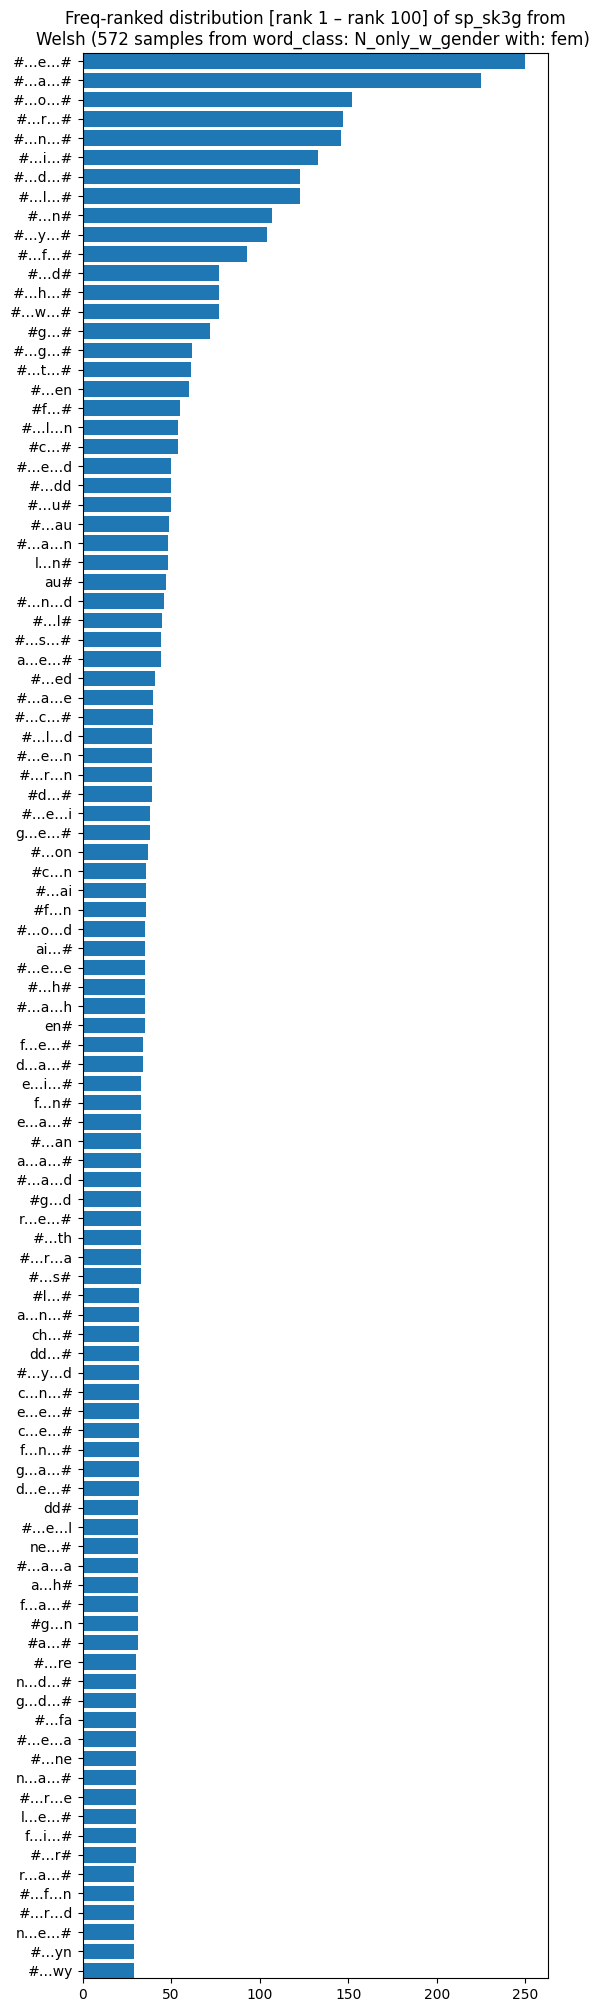

In [83]:
## frequency-ranked view
skippy = True
prefix = "sp_"
n_local = 3
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [84]:
## spell skippy 4grams
add_ngram_to_df(df, n_for_ngram = 4, prefix = "sp_", skippy = True, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_sk4gram
min_size: 1
supplement_var: sp_sk3gram
2768    [#gor, #go…s, #go…#, #g…rs, #g…r…#, #g…s#, #…o...
4503    [#dwy, #dw…n, #dw…w, #dw…e, #dw…n, #dw…#, #d…y...
1349    [#rho, #rh…s, #rh…#, #r…os, #r…o…#, #r…s#, #…h...
3242    [#awr, #aw…#, #a…r#, #…wr#, awr#, #aw, #a…r, #...
4010    [#str, #st…y, #st…d, #st…#, #s…ry, #s…r…d, #s…...
                              ...                        
2442    [#nge, #ng…n, #ng…e, #ng…t, #ng…h, #ng…#, #n…e...
331     [#ewy, #ew…l, #ew…l, #ew…y, #ew…s, #ew…#, #e…y...
2789    [#ffo, #ff…n, #ff…#, #f…on, #f…o…#, #f…n#, #…f...
3096    [#aff, #af…r, #af…i, #af…c, #af…a, #af…#, #a…f...
3426    [#cyn, #cy…f, #cy…f, #cy…o, #cy…n, #cy…#, #c…n...
Name: sp_sk4gram, Length: 519, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_66176/3820207768.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


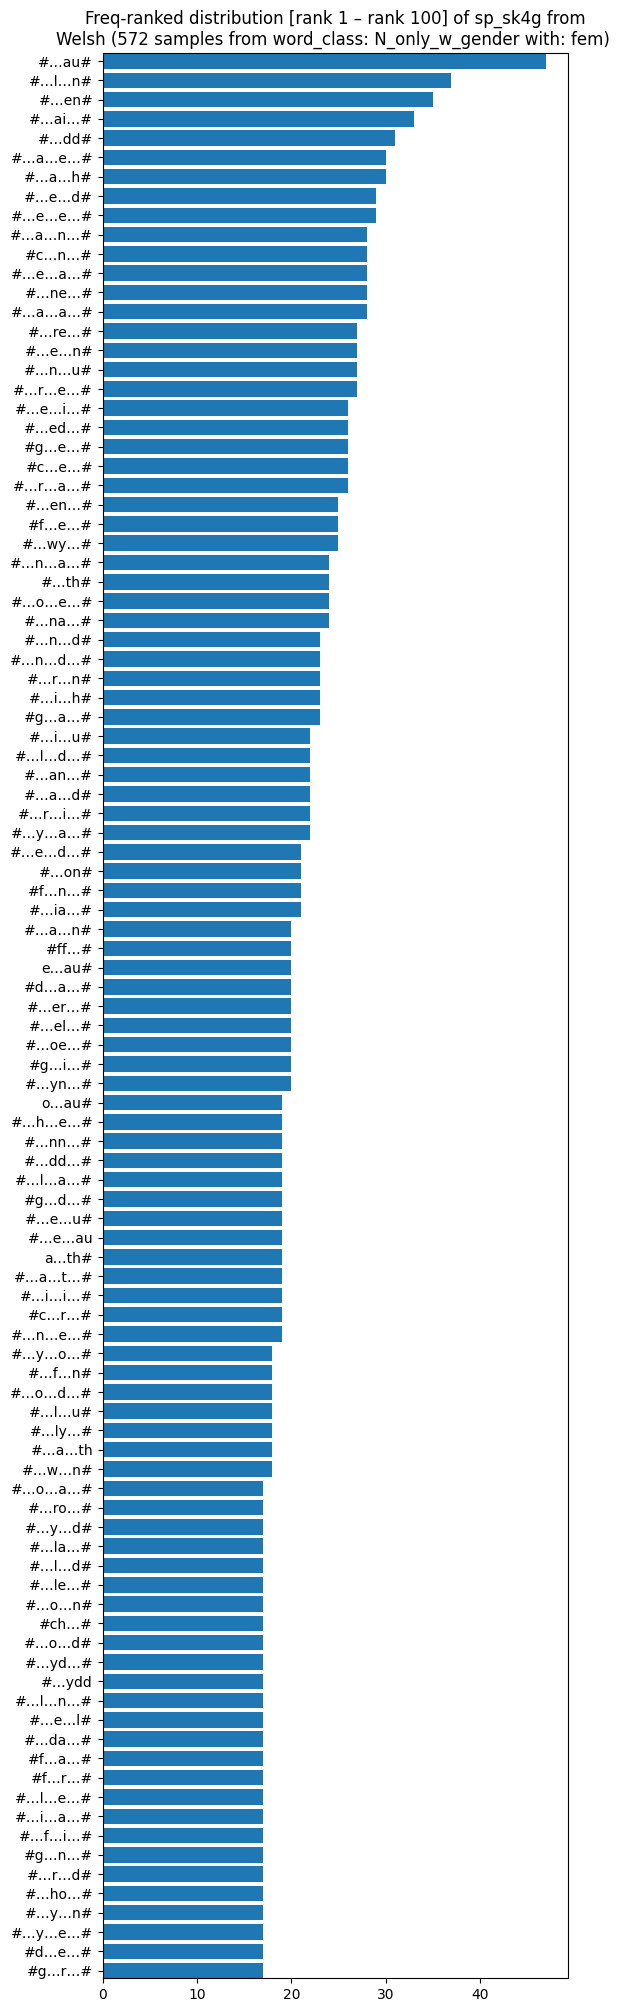

In [85]:
## frequency-ranked view
skippy = True
prefix = "sp_"
n_local = 4
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [86]:
## spell skippy 5grams
add_ngram_to_df(df, n_for_ngram = 5, prefix = "sp_", skippy = True, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_sk5gram
min_size: 1
supplement_var: sp_sk4gram
2768    [#gors, #gor…#, #go…s#, #g…rs#, #…ors#, gors#,...
4503    [#dwyn, #dwy…w, #dwy…e, #dwy…n, #dwy…#, #dw…nw...
1349    [#rhos, #rho…#, #rh…s#, #r…os#, #…hos#, rhos#,...
3242    [#awr#, #awr, #aw…#, #a…r#, #…wr#, awr#, #aw, ...
4010    [#stry, #str…d, #str…#, #st…yd, #st…y…#, #st…d...
                              ...                        
2442    [#ngen, #nge…e, #nge…t, #nge…h, #nge…#, #ng…ne...
331     [#ewyl, #ewy…l, #ewy…y, #ewy…s, #ewy…#, #ew…ll...
2789    [#ffon, #ffo…#, #ff…n#, #f…on#, #…fon#, ffon#,...
3096    [#affr, #aff…i, #aff…c, #aff…a, #aff…#, #af…ri...
3426    [#cynf, #cyn…f, #cyn…o, #cyn…n, #cyn…#, #cy…ff...
Name: sp_sk5gram, Length: 519, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_66176/3820207768.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


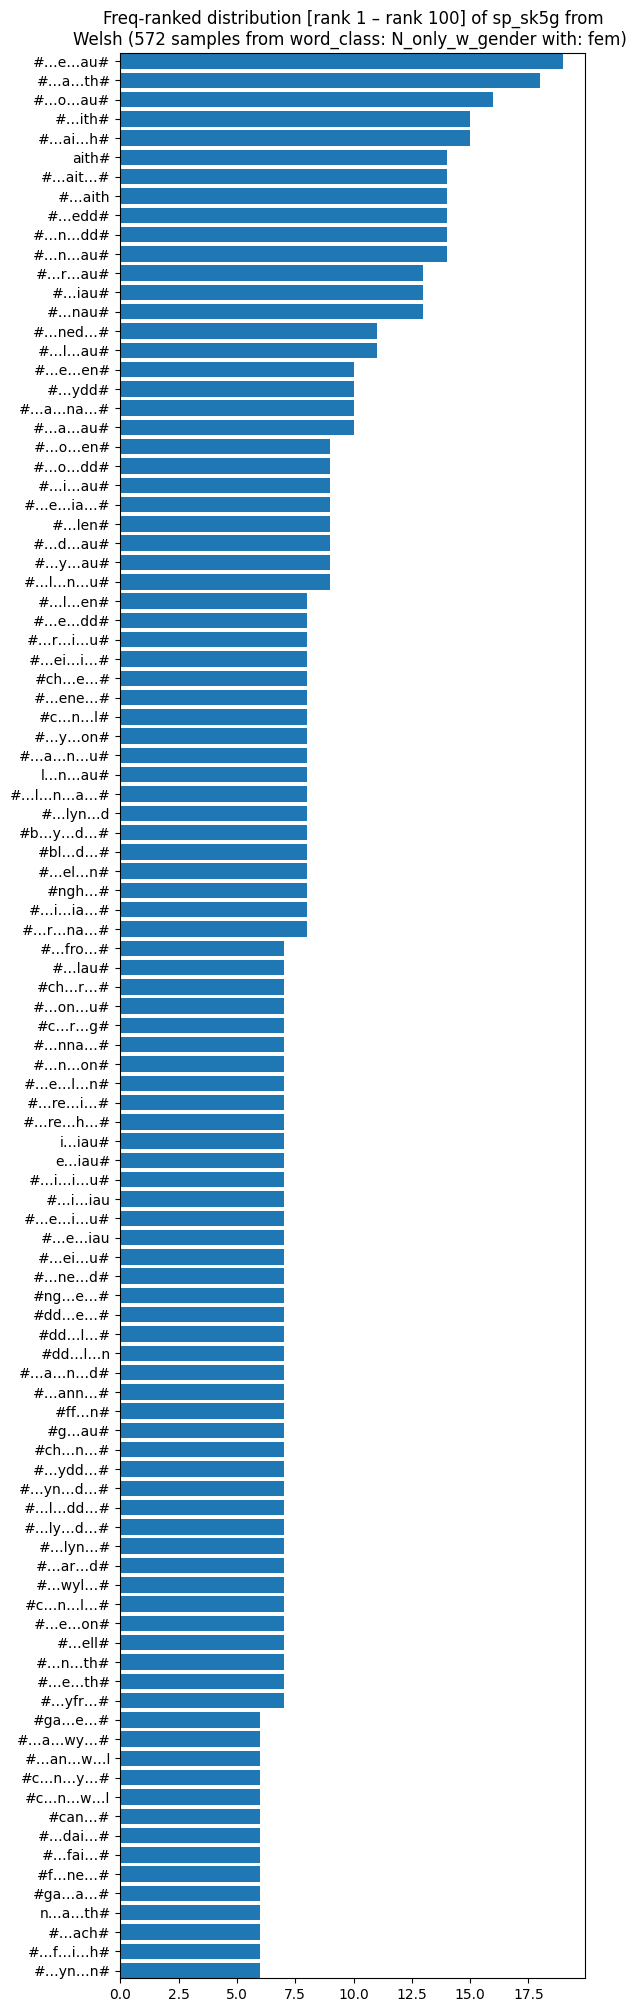

In [87]:
## frequency-ranked view
skippy = True
prefix = "sp_"
n_local = 5
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

## Sound

In [88]:
## stop for unimplemented language
if target_lang_name in [ 'Irish', 'Welsh' ]:
    import sys
    sys.exit()

SystemExit: 

/Volumes/K/opt/anaconda3/envs/py3.11/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3534: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### Non-skippy sound

In [ ]:
## sound 2grams
add_ngram_to_df(df, n_for_ngram = 2, skippy = False, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

In [ ]:
## frequency-ranked view
skippy = False
prefix = "sn_"
n_local = 2
#rank_range = (1,100)
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [ ]:
## sound 3grams
add_ngram_to_df(df, n_for_ngram = 3, skippy = False, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

In [ ]:
## frequency-ranked view
skippy = False
prefix = "sn_"
n_local = 3
#rank_range = (1,100)
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [ ]:
## sound 4grams
add_ngram_to_df(df, n_for_ngram = 4, skippy = False, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

In [ ]:
## frequency-ranked view
skippy = False
prefix = "sn_"
n_local = 4
#rank_range = (1,100)
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [ ]:
## sound 5grams
add_ngram_to_df(df, n_for_ngram = 5, skippy = False, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

In [ ]:
## frequency-ranked view
skippy = False
prefix = "sn_"
n_local = 5
#rank_range = (1,100)
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

### skippy sound

In [ ]:
## sound skippy 2grams
add_ngram_to_df(df, n_for_ngram = 2, skippy = True, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

In [ ]:
## frequency-ranked view
skippy = True
prefix = "sn_"
n_local = 2
#rank_range = (1,100)
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [ ]:
## sound skippy 3grams
add_ngram_to_df(df, n_for_ngram = 3, skippy = True, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

In [ ]:
## frequency-ranked view
skippy = True
prefix = "sn_"
n_local = 3
#rank_range = (1,100)
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [ ]:
## sound skippy 4grams
add_ngram_to_df(df, n_for_ngram = 4, prefix = "sn_", skippy = True, inclusive = True, inclusion_degree = inclusion_degree, check = False)

In [ ]:
## frequency-ranked view
skippy = True
prefix = "sn_"
n_local = 4
#rank_range = (1,100)
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [ ]:
## sound skippy 5grams
add_ngram_to_df(df, n_for_ngram = 5, skippy = True, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

In [ ]:
## frequency-ranked view
skippy = True
prefix = "sn_"
n_local = 5
#rank_range = (1,100)
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

# End